<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Multimodal RAG with Document Retrieval (ColPali), Amazon Nova and CrewAI
</h1>.

![Agentic RAG](./Multimodal-RAG.png)

In [ ]:
# %pip install colpali-engine torch boto3 tqdm pymupdf numpy matplotlib einops seaborn -q
# %pip install boto3==1.34.162 botocore==1.34.162 crewai==0.70.1 crewai_tools==0.12.1 duckduckgo-search==6.3.1 PyPDF2==3.0.1 -q 

In [1]:
import requests
import os
import torch
import qdrant_client
import time
import shutil
import boto3
import os

from huggingface_hub import login
from dotenv import load_dotenv
from colpali_engine.models import ColPali, ColPaliProcessor
from pdf2image import convert_from_path
from qdrant_client.http import models
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from crewai import Agent, Task, Crew, LLM, Process
from crewai_tools import tool
from IPython.display import Markdown


/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Loading the PDF files (Dataset)
</h1>

In [2]:

# Download pdfs from different sources 
def download_pdf(pdfs, output_dir):
    for name, url in pdfs.items():
        response = requests.get(url)
        pdf_path = os.path.join(output_dir, f"{name}.pdf")

        with open(pdf_path, "wb") as f:
            f.write(response.content)

        print(f"Downloaded {name} to {pdf_path}")

In [3]:
pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf",
}

# Downloading the PDF files 
pdf_dir = "pdf_data"
os.makedirs(pdf_dir, exist_ok=True)

download_pdf(pdfs, pdf_dir)


Downloaded MALM to pdf_data/MALM.pdf
Downloaded BILLY to pdf_data/BILLY.pdf
Downloaded BOAXEL to pdf_data/BOAXEL.pdf
Downloaded ADILS to pdf_data/ADILS.pdf
Downloaded MICKE to pdf_data/MICKE.pdf


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Load the ColPali Multimodal Document Retrieval Model
</h1>

In [4]:
# Load environment variables
load_dotenv()

# Login using token from environment variable
login(token=os.getenv('HUGGING_FACE_TOKEN'))

In [5]:
# Check if CUDA/MPS/CPU is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'mps'


In [ ]:

model_name = "vidore/colpali-v1.2"

colpali_model = ColPali.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device, 
                cache_dir="./model_cache"
            )

colpali_processor = ColPaliProcessor.from_pretrained(
                pretrained_model_name_or_path=model_name,
                cache_dir="./model_cache"
            )

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Setup vector database
</h1>

### Run it on the shell 

```
docker run -p 6333:6333 -p 6334:6334 \
    -v $(pwd)/qdrant_storage:/qdrant/storage:z \
    qdrant/qdrant
```

### Check the Qdrant vector database in the browser

```
http://localhost:6333/dashboard#/welcome
```



In [12]:

client = qdrant_client.QdrantClient(
    host="localhost",
    port=6333
)

In [13]:
client.info()

VersionInfo(title='qdrant - vector search engine', version='1.13.4', commit='7abc684361fb81d8b62cf1554d8bf4fb65a706d7')

In [14]:
# Collection name
COLLECTION_NAME = "my_collection"
VECTOR_SIZE = 128

# Create a collection
client.create_collection(
    collection_name=COLLECTION_NAME,
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=VECTOR_SIZE,
        distance=models.Distance.COSINE,
        on_disk=True,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
    ),
)

True

Verify the collection [here](http://localhost:6333/dashboard#/collections)

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Store embeddings in vector database
</h1>

In [15]:
def convert_pdfs_to_images(pdf_folder, poppler_path="/opt/homebrew/bin"):
    """Convert PDFs into a dictionary of PIL images."""
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = []

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path, poppler_path=poppler_path)
        
        for page_num, image in enumerate(images):
            all_images.append({"doc_id": doc_id, "page_num": page_num, "image": image.convert("RGB")})

    return all_images

PDF_DIR = pdf_dir  # Change this to your actual folder path
dataset = convert_pdfs_to_images(PDF_DIR)


In [16]:
dataset

[{'doc_id': 0,
  'page_num': 0,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 1,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 2,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 3,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 4,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 5,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 6,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 7,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 8,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 9,
  'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
 {'doc_id': 0,
  'page_num': 10,
  'image': <PIL.Image.Image image mod

In [17]:

BATCH_SIZE = 4
print("Generating embeddings and storing in Qdrant...")

with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[i : i + BATCH_SIZE]

        # Extract images
        images = [item["image"] for item in batch]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(colpali_model.device)
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            points.append(
                models.PointStruct(
                    id=i + j,  # Use the batch index as the ID
                    vector=embedding.tolist(),  # Convert to list
                    payload={
                        "doc_id": batch[j]["doc_id"],
                        "page_num": batch[j]["page_num"],
                        "source": "pdf archive",
                    },  
                )
            )

        # Upload points to Qdrant
        try:
            client.upsert(collection_name=COLLECTION_NAME, points=points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(BATCH_SIZE)

print("Indexing complete!")

Generating embeddings and storing in Qdrant...


Indexing Progress: 100%|██████████| 96/96 [06:02<00:00,  3.78s/it]

Indexing complete!


In [18]:
query_text = "How many people are needed to assemble the Malm?"

with torch.no_grad():
    text_embedding = colpali_processor.process_queries([query_text]).to(colpali_model.device)  
    text_embedding = colpali_model(**text_embedding)

token_query = text_embedding[0].cpu().float().numpy().tolist()

start_time = time.time()

query_result = client.query_points(collection_name=COLLECTION_NAME,
                                   query=token_query,
                                   limit=5,
                                   search_params=models.SearchParams(
                                   quantization=models.QuantizationSearchParams(
                                   ignore=True,
                                   rescore=True,
                                   oversampling=2.0
                                   )
                               )
                           )

print(f"Time taken = {(time.time()-start_time):.3f} s")


Time taken = 0.104 s


In [19]:
query_result.points

[ScoredPoint(id=52, version=13, score=13.890652, payload={'doc_id': 3, 'page_num': 0, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=54, version=13, score=11.503966, payload={'doc_id': 3, 'page_num': 2, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=92, version=23, score=11.354334, payload={'doc_id': 4, 'page_num': 12, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=21, version=5, score=11.313353, payload={'doc_id': 0, 'page_num': 21, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=18, version=4, score=11.164216, payload={'doc_id': 0, 'page_num': 18, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None)]

In [20]:
# Define a folder to save matched images
MATCHED_IMAGES_DIR = "matched_images"

# Delete all files and the directory itself if it exists
if os.path.exists(MATCHED_IMAGES_DIR):
    shutil.rmtree(MATCHED_IMAGES_DIR)

os.makedirs(MATCHED_IMAGES_DIR)

# Extract matched images from dataset based on query_result
matched_images = []
matched_images_path = []

for result in query_result.points:
    doc_id = result.payload["doc_id"]
    page_num = result.payload["page_num"]

    # Find the matching image in dataset
    for item in dataset:
        if item["doc_id"] == doc_id and item["page_num"] == page_num:
            matched_images.append(item["image"])
            
            # Save the matched image
            image_filename = os.path.join(MATCHED_IMAGES_DIR, f"match_doc_{doc_id}_page_{page_num}.png")
            item["image"].save(image_filename, "PNG")
            matched_images_path.append(image_filename)
            print(f"✅ Saved: {image_filename}")
            
            break  

print("\n📂 All matched images are saved in the 'matched_images' folder.")


✅ Saved: matched_images/match_doc_3_page_0.png
✅ Saved: matched_images/match_doc_3_page_2.png
✅ Saved: matched_images/match_doc_4_page_12.png
✅ Saved: matched_images/match_doc_0_page_21.png
✅ Saved: matched_images/match_doc_0_page_18.png

📂 All matched images are saved in the 'matched_images' folder.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Visualizing the matched images
</h1>

In [21]:

def display_image_grid(images, num_cols=5, figsize=(15, 10)):
    """
    Display a grid of images using matplotlib.
    
    Args:
        images: List of images to display
        num_cols: Number of columns in the grid (default: 8)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate needed rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flat  # Flatten axes array for easier iteration
    
    # Display images
    for i in range(num_cols * num_rows):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

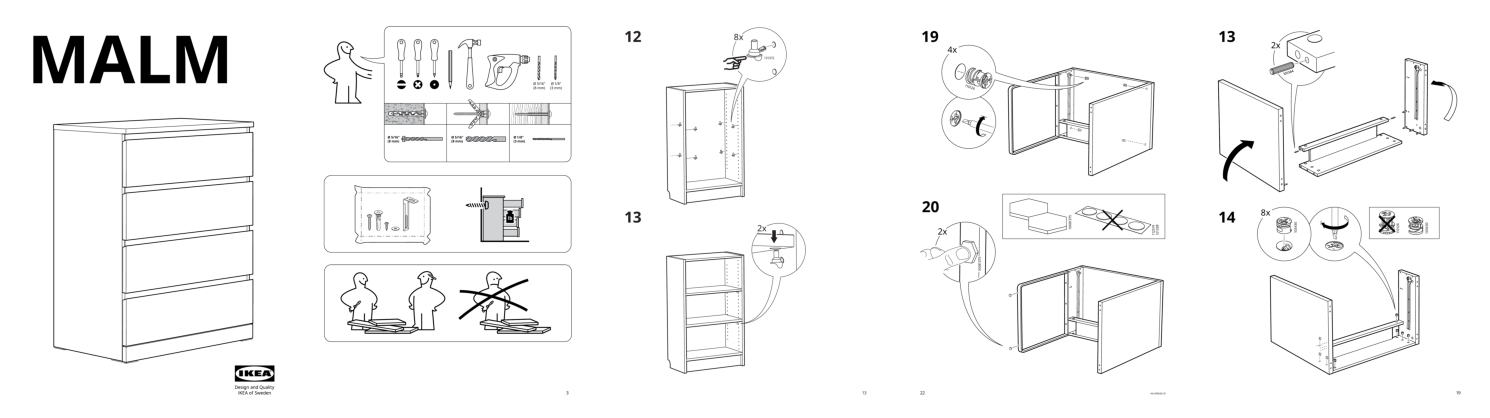

In [22]:
display_image_grid(matched_images)

In [23]:
def read_and_encode_image(image_path: str):

    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()
        
    image_format = Image.open(image_path).format.lower()

    message_content = {
                    "image": {
                        "format": image_format,
                        "source": {"bytes": image_bytes},
                    }
                }
    
    return message_content


def send_images_to_model_using_converse(matched_items: list, query: str, model_id: str):

    system_prompt = 'You are a helpful assistant for question answering. Given the context, answer the question. Do not include any other text than the answer.'

    image_list = []
    for image_path in matched_items:
        image_list.append({
            "image_path": image_path, 
        })

    content_list = []
    for img in image_list:
        message_content = read_and_encode_image(img['image_path'])
        content_list.append(message_content)
    
    content_list.append({"text": query})
    system = [ { "text": system_prompt } ]
    
    # Define a "user" message including both the image and a text prompt.
    messages = [
        {
            "role": "user",
            "content": content_list,
        }
    ]
    
    # Configure the inference parameters.
    inf_params = {"temperature": .3, "maxTokens": 5000}
    
    # Initialize the Bedrock client
    client = boto3.client('bedrock-runtime', region_name='us-east-1')

    response = client.converse(
        modelId=model_id, 
        messages=messages,
        system=system, 
        inferenceConfig=inf_params
    )
    
    # Print Response
    output_message = response["output"]["message"]["content"][0]["text"]

    return output_message

In [24]:
PRO_MODEL_ID = "amazon.nova-pro-v1:0"
LITE_MODEL_ID = "amazon.nova-lite-v1:0"
MICRO_MODEL_ID = "amazon.nova-micro-v1:0"

response = send_images_to_model_using_converse(matched_items=matched_images_path, query=query_text, model_id=PRO_MODEL_ID)
print(response)

/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/botocore/auth.py:419: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime_now = datetime.datetime.utcnow()


2 people are needed to assemble the Malm, as shown in the bottom right image on page 3.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Use the Knowledge Base with Agents using CrewAI
</h1>

In [25]:
# ---------------------- Initialize CrewAI LLM (Amazon Nova Pro) ----------------------
model_id = "us.amazon.nova-pro-v1:0"  
llm = LLM(model=model_id)

# ---------------------- Create a Retrieval Tool ----------------------
@tool
def retrieve_from_qdrant(query: str):
    """
    Retrieve the most relevant documents from Qdrant vector database
    based on the given text query.
    
    Args:
        query (str): The user query to search in the knowledge base.
    
    Returns:
        list: List of paths to the matched images.
    """
    global client, COLLECTION_NAME, colpali_processor, colpali_model

    print(f"🔍 Retrieving documents for query: {query}")
    
    with torch.no_grad():
        text_embedding = colpali_processor.process_queries([query]).to(colpali_model.device)  
        text_embedding = colpali_model(**text_embedding)

    token_query = text_embedding[0].cpu().float().numpy().tolist()
    start_time = time.time()

    # Perform search in Qdrant
    query_result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=token_query,
        limit=5,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                ignore=True,
                rescore=True,
                oversampling=2.0
            )
        )
    )

    print(f"⏳ Query Time: {(time.time()-start_time):.3f} s")

    matched_images_path = []

    for result in query_result.points:
        doc_id = result.payload["doc_id"]
        page_num = result.payload["page_num"]

        for item in dataset:
            if item["doc_id"] == doc_id and item["page_num"] == page_num:
                image_filename = os.path.join("matched_images", f"match_doc_{doc_id}_page_{page_num}.png")
                item["image"].save(image_filename, "PNG")
                matched_images_path.append(image_filename)

                print(f"✅ Saved: {image_filename}")
                break  

    print("\n📂 All matched images are saved in the 'matched_images' folder.")
    
    return matched_images_path

# ---------------------- Define the Retrieval Agent ----------------------
retrieval_agent = Agent(
    role="Knowledge Retriever",
    goal="Retrieve the most relevant images from the knowledge base based on the query.",
    backstory="An AI librarian with expertise in technical documentation, diagrams, and manuals.",
    tools=[retrieve_from_qdrant],  # ✅ Uses the retrieval tool
    allow_delegation=False,
    verbose=True,
    llm=llm
)

# ---------------------- Define the Multimodal Answering Agent ----------------------
answering_agent = Agent(
    role="Multimodal Knowledge Expert",
    goal=f"Accurately interpret the provided images and extract relevant information to answer the question: {{query_text}}.",
    backstory="An advanced AI specialized in multimodal reasoning, capable of analyzing both text and images to provide the most precise and insightful answers.",
    multimodal=True,  # ✅ Enables multimodal processing
    allow_delegation=False,
    verbose=True,
    llm=llm
)

# ---------------------- Define the Tasks ----------------------
retrieval_task = Task(
    description="Retrieve the most relevant images from the knowledge base based on the given query.",
    agent=retrieval_agent,  # Assign retrieval agent
    expected_output="A list of image file paths related to the query."
)

qa_task = Task(
    description="Using the retrieved images at {{matched_images_path}}, generate a precise answer to the query: {{query_text}}.",
    agent=answering_agent,  # Assign answering agent
    expected_output="A clear and well-structured explanation based on the extracted information from the images. No need to include reference to the images in the answer.",
)

# ---------------------- Assemble the Crew ----------------------
crew = Crew(
    agents=[retrieval_agent, answering_agent],
    tasks=[retrieval_task, qa_task],  
    process=Process.sequential,
    verbose=False
)


/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/crewai_tools/tools/base_tool.py:93: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  for arg, attribute in self.args_schema.schema()["properties"].items():
/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]
/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in 

In [26]:
# ---------------------- Run the Query ----------------------
query_text = "How many people are needed to assemble the Malm?"
result = crew.kickoff(inputs={"query_text": query_text})

/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]
/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]


# Agent: Knowledge Retriever
## Task: Retrieve the most relevant images from the knowledge base based on the given query.


/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/crewai/tools/tool_usage.py:162: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  acceptable_args = tool.args_schema.schema()["properties"].keys()  # type: ignore # Item "None" of "type[BaseModel] | None" has no attribute "schema"
/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/langchain_core/tools/base.py:424: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = input_args.parse_obj(tool_input)
/opt/anaconda3/envs/rag_env2/lib/python3.12/site-packages/langchain_core/tools/base.py:427: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` inst

🔍 Retrieving documents for query: network topology diagrams
⏳ Query Time: 0.067 s
✅ Saved: matched_images/match_doc_1_page_18.png
✅ Saved: matched_images/match_doc_3_page_13.png
✅ Saved: matched_images/match_doc_2_page_1.png
✅ Saved: matched_images/match_doc_4_page_12.png
✅ Saved: matched_images/match_doc_4_page_6.png

📂 All matched images are saved in the 'matched_images' folder.


# Agent: Knowledge Retriever
## Thought: Thought: I need to retrieve the most relevant images from the knowledge base based on the given query. I will use the `retrieve_from_qdrant` tool to search for the images.
## Using tool: retrieve_from_qdrant
## Tool Input: 
"{\"query\": \"network topology diagrams\"}"
## Tool Output: 
['matched_images/match_doc_1_page_18.png', 'matched_images/match_doc_3_page_13.png', 'matched_images/match_doc_2_page_1.png', 'matched_images/match_doc_4_page_12.png', 'matched_images/match_doc_4_page_6.png']


# Agent: Knowledge Retriever
## Final Answer: 
['matched_images/match_doc_1_

In [27]:
Markdown(result.raw)

Based on the analysis of the provided images, the assembly of the Malm typically requires two people. This conclusion is drawn from the complexity of the assembly process depicted in the images, which includes handling large panels and securing multiple components. The instructions and diagrams suggest that having an additional person to hold pieces in place while the other person screws or fits them together would make the process more efficient and safer.